<a href="https://colab.research.google.com/github/Roua91/Reaserch_Project/blob/main/Copy_of_Q3_Hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Importing necessary libraries

In [1]:
!pip install pennylane

# 2- Importing and preprocessing the dataset

In [2]:
from google.colab import files
uploaded = files.upload()


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
  name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
breast-ultrasound-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
from zipfile import ZipFile
file_name = "/content/breast-ultrasound-images-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()  # This line is indented
print('Done')

Done


In [5]:
import os

# Path to the dataset directory
dataset_dir = '/content/Dataset_BUSI_with_GT'

import shutil


# Path to the 'normal' directory
normal_dir_path = '/content/Dataset_BUSI_with_GT/normal'

# Check if the directory exists
if os.path.exists(normal_dir_path) and os.path.isdir(normal_dir_path):
    # Remove the 'normal' directory and all its contents
    shutil.rmtree(normal_dir_path)
    print(f"'{normal_dir_path}' has been removed.")
else:
    print(f"The directory '{normal_dir_path}' does not exist or is not a directory.")

all_files = os.listdir(dataset_dir)
print(all_files)



'/content/Dataset_BUSI_with_GT/normal' has been removed.
['benign', 'malignant']


In [6]:
from PIL import Image
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Overlay and preparation code
dataset_dir = '/content/Dataset_BUSI_with_GT'  # Original dataset directory
overlay_dir = '/content/OverlayOutput'  # Directory to save overlayed images
labels = ['benign', 'malignant']

# Ensure the overlay output directory exists
os.makedirs(overlay_dir, exist_ok=True)
# Create subdirectories for each label in the overlay directory
for label in labels:
    os.makedirs(os.path.join(overlay_dir, label), exist_ok=True)


def overlay_and_save(image_path, mask_path, output_dir):
    try:
        output_path = os.path.join(output_dir, os.path.basename(image_path))

        # Check if the overlay image already exists
        if os.path.isfile(output_path):
            print(f"Overlay image already exists: {output_path}, skipping.")
            return  # Skip saving this image

        # Proceed if the overlay does not exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            image = Image.open(image_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            mask = mask.resize(image.size)  # Resize mask to match image size

            # Create an RGBA version of the mask to use as overlay
            rgba_mask = Image.new("RGBA", mask.size, (255, 192, 77, 0))
            rgba_mask.putalpha(mask)

            overlayed = Image.alpha_composite(image.convert("RGBA"), rgba_mask)

            # Save the overlayed image
            overlayed.convert("RGB").save(output_path)  # Convert back to RGB to save
            print(f"Saved overlayed image to: {output_path}")
    except Exception as e:
        print(f"An error occurred for: {image_path} or {mask_path}. Error: {str(e)}")

# Perform overlay and save for each image in the dataset
for label in labels:
    image_dir = os.path.join(dataset_dir, label)
    output_label_dir = os.path.join(overlay_dir, label)
    for image_filename in os.listdir(image_dir):
        if image_filename.endswith('.png'):
            image_path = os.path.join(image_dir, image_filename)
            mask_path = image_path.replace('.png', '_mask.png')
            overlay_and_save(image_path, mask_path, output_label_dir)

print("Overlayed images have been saved to the overlay directory.")

# Now proceed with loading and transforming the overlayed dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(p=0.9),
    transforms.RandomRotation(15, expand=False, center=None),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the overlayed dataset
overlayed_dataset = datasets.ImageFolder(root=overlay_dir, transform=transform)

# Splitting dataset into train and test sets
train_idx, test_idx = train_test_split(range(len(overlayed_dataset)), test_size=0.2, random_state=42)

# Creating data loaders
train_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(train_idx))
test_loader = DataLoader(overlayed_dataset, batch_size=32, sampler=SubsetRandomSampler(test_idx))

dataloaders = {'train': train_loader, 'test': test_loader}
dataset_sizes = {'train': len(train_idx), 'test': len(test_idx)}
class_names = overlayed_dataset.classes

print(f"Dataset split complete: {len(train_loader)} training batches, {len(test_loader)} testing batches.")

Overlay image already exists: /content/OverlayOutput/benign/benign (141).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (73).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (107).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (284).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (170).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (130).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (436).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (276).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (258).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (327).png, skipping.
Overlay image already exists: /content/OverlayOutput/benign/benign (289).png, skipping.
Overlay image already exists: /co

# 3- Quatum Circuit

In [7]:
import time
n_qubits = 4              # Number of qubits
step = 0.00041             # Learning rate
batch_size = 5              # Number of samples for each training step
num_epochs = 30           # Number of training epochs
q_depth = 3               # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [8]:
import pennylane as qml
import torch
import torch.nn as nn


dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Quantum functions remain as you have defined them
def H_layer(nqubits):
    """Apply a layer of Hadamard gates to all qubits."""
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RY_layer(w):
    """Apply a layer of parametrized rotation-y gates."""
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def RZ_layer(w):
    """Apply a layer of parametrized rotation-z gates."""
    for idx, element in enumerate(w):
        qml.RZ(element, wires=idx)

def entangling_layer(nqubits):
    """Apply a layer of CNOT gates for entanglement."""
    for i in range(nqubits):
        qml.CNOT(wires=[i, (i + 1) % nqubits])

def CZ_layer(nqubits):
    """Apply a layer of controlled-Z gates for phase entanglement."""
    for i in range(nqubits):
        qml.CZ(wires=[i, (i + 1) % nqubits])

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, 2, n_qubits)

    H_layer(n_qubits)
    RY_layer(q_input_features)

    for depth in range(q_depth):
        RY_layer(q_weights[depth][0])
        RZ_layer(q_weights[depth][1])
        entangling_layer(n_qubits)
        CZ_layer(n_qubits)

    return tuple(qml.expval(qml.PauliZ(i)) for i in range(n_qubits))

class DressedQuantumNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_net = nn.Linear(2048, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * 2 * n_qubits))  # Adjusted for 2 types of gates
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Proper tensor initialization
        q_out = torch.zeros(size=(0, n_qubits), device=device)  # Ensure tensor is on the correct device

        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        return self.post_net(q_out)

# Ensure further components such as training loop, data loading are correctly implemented


# 4- Hybrid Classical Quantum Model

In [9]:
import torchvision
model_hybrid = torchvision.models.resnet50(pretrained=True)

#freeze classical model perameters
for param in model_hybrid.parameters():
    param.requires_grad = False


# model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()


model_hybrid = model_hybrid.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 5- Training and Result

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
import torch.optim as optim
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [12]:
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [13]:
import torch
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes, device):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')  # Initialize with a large number

    print("Training started:")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and test phase for evaluation
        for phase in ['train', 'test']:  # Use 'test' instead of 'validation'
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                'Train' if phase == 'train' else 'Test',
                epoch_loss, epoch_acc))

            # Deep copy the model if we get the best accuracy on the test set
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_loss = epoch_loss

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test loss: {:.4f} Acc: {:.4f}'.format(best_loss, best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
model_hybrid = train_model(
    model_hybrid,
    criterion,
    optimizer_hybrid,
    exp_lr_scheduler,
    num_epochs=num_epochs,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device
)

Training started:
Epoch 1/30
----------
Train Loss: 0.7205 Acc: 0.4565
Test Loss: 0.6827 Acc: 0.7000
Epoch 2/30
----------
Train Loss: 0.6572 Acc: 0.6673
Test Loss: 0.6314 Acc: 0.7000
Epoch 3/30
----------
Train Loss: 0.6435 Acc: 0.6692
Test Loss: 0.6287 Acc: 0.7000
Epoch 4/30
----------
Train Loss: 0.6417 Acc: 0.6692
Test Loss: 0.6268 Acc: 0.7000
Epoch 5/30
----------
Train Loss: 0.6403 Acc: 0.6692
Test Loss: 0.6244 Acc: 0.7000
Epoch 6/30
----------
Train Loss: 0.6376 Acc: 0.6692
Test Loss: 0.6044 Acc: 0.7000
Epoch 7/30
----------
Train Loss: 0.5963 Acc: 0.6963
Test Loss: 0.5598 Acc: 0.7615
Epoch 8/30
----------
Train Loss: 0.5629 Acc: 0.7988
Test Loss: 0.5372 Acc: 0.9077
Epoch 9/30
----------
Train Loss: 0.5402 Acc: 0.8723
Test Loss: 0.5127 Acc: 0.9077
Epoch 10/30
----------
Train Loss: 0.5259 Acc: 0.8627
Test Loss: 0.5058 Acc: 0.9615
Epoch 11/30
----------
Train Loss: 0.5166 Acc: 0.9168
Test Loss: 0.4887 Acc: 0.9385
Epoch 12/30
----------
Train Loss: 0.5116 Acc: 0.8936
Test Loss: 0.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Mean and standard deviation used for ImageNet dataset normalization
# These values may need to be adjusted based on your dataset's normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def imshow(inp, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert tensor to (HxWxC) from (CxHxW)
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip values to [0, 1] range
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=6, fig_name="Predictions", num_cols=2):
    images_so_far = 0
    fig = plt.figure(fig_name, figsize=(10, num_images * 2))

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = plt.subplot(num_images // num_cols + num_images % num_cols, num_cols, images_so_far)
                    ax.axis('off')
                    ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}', fontsize=9)

                    # imshow function needs to be defined or use plt.imshow after converting tensor to numpy
                    imshow(inputs.cpu().data[j])
                else:
                    plt.tight_layout()
                    return
        plt.tight_layout()

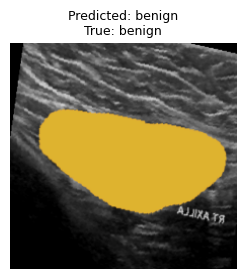

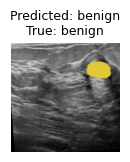

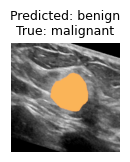

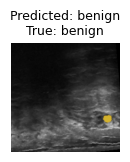

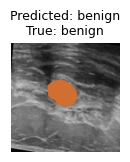

<Figure size 640x480 with 0 Axes>

In [16]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

# 6- Evaluation

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, cohen_kappa_score
import torch

def evaluate_model(model, dataloaders, device):
    model.eval()  # Set the model to evaluation mode
    true_labels_list, predictions_list, probabilities_list = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification
            _, preds = torch.max(outputs, 1)

            true_labels_list.extend(labels.cpu().numpy())
            predictions_list.extend(preds.cpu().numpy())
            probabilities_list.extend(probabilities.cpu().numpy())

    # Calculating metrics
    accuracy = accuracy_score(true_labels_list, predictions_list)
    precision = precision_score(true_labels_list, predictions_list, average='binary')
    recall = recall_score(true_labels_list, predictions_list, average='binary')
    f1 = f1_score(true_labels_list, predictions_list, average='binary')
    auc = roc_auc_score(true_labels_list, probabilities_list)
    mcc = matthews_corrcoef(true_labels_list, predictions_list)  # Matthews Correlation Coefficient
    kappa = cohen_kappa_score(true_labels_list, predictions_list)  # Cohen's Kappa

    # Print metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')
    print(f'MCC: {mcc:.4f}')
    print(f'Kappa: {kappa:.4f}')


    # Confusion Matrix
    cm = confusion_matrix(true_labels_list, predictions_list)
    print("Confusion Matrix:")
    print(cm)

In [18]:
evaluate_model(model_hybrid, dataloaders, device)

Accuracy: 0.9385
Precision: 0.9697
Recall: 0.8205
F1 Score: 0.8889
AUC: 0.9927
MCC: 0.8524
Kappa: 0.8467
Confusion Matrix:
[[90  1]
 [ 7 32]]
